In [1]:
# Set plot options in Jupyter Lab 
options(repr.plot.width = 20)
options(repr.plot.height = 6)

# Simulation example

Below we will simulate two cointegrated series.

$
\begin{aligned}
Y_t &= \beta_2 X_t + u_t,\ u_t \sim I(0)\\
X_t &= X_{t-1} + v_t,\ v_t \sim I(0)
\end{aligned}
$

where $\beta_2$ is the cointegrating parameter.

In this case  $Y_t \sim I(1)$ and $X_t \sim I(0)$. Notice that the first equation gives the long-run equilibrium relationship $Y_t - \beta_2 X_t = u_t \sim I(0)$, i.e. the first equation gives the linear combination of $X_t$ and $Y_t$, which is stationary. The second relationship is the common stochastic trend (i.e. unit root) relationship that we are already familiar with.


Further examples can be found at [this answer on stackoverflow](https://quant.stackexchange.com/questions/3930/how-to-simulate-cointegrated-prices). A more [advanced example can be found in this paper](https://www.informs-sim.org/wsc09papers/047.pdf).


For this example, we will choose:

- $\beta_2 = 1$ (notice that it does not matter what kind of parameter we choose, since the first equation will be equivalent to the cointegration relationship, as long as $u_t \sim I(0)$).
- $u_t = 0.6 u_{t-1} + \epsilon_t$, $\epsilon_t \sim \mathcal{N}(0, 0.5^2)$;
- $v_t \sim \mathcal{N}(0, 0.5^2)$;

In [2]:
set.seed(123)
#
N <- 500
sd_u <- 0.5
sd_v <- 0.5
#
eps <- MASS::mvrnorm(N, mu = c(0, 0), Sigma = diag(c(sd_u, sd_v)))
#
u <- arima.sim(model = list(ar = 0.6), innov = eps[, 1], n = N)
v <- eps[, 2]
#
X <- cumsum(v)
Y <- X + u

In [3]:
Y <- ts(Y)
X <- ts(X)

We can examine the series

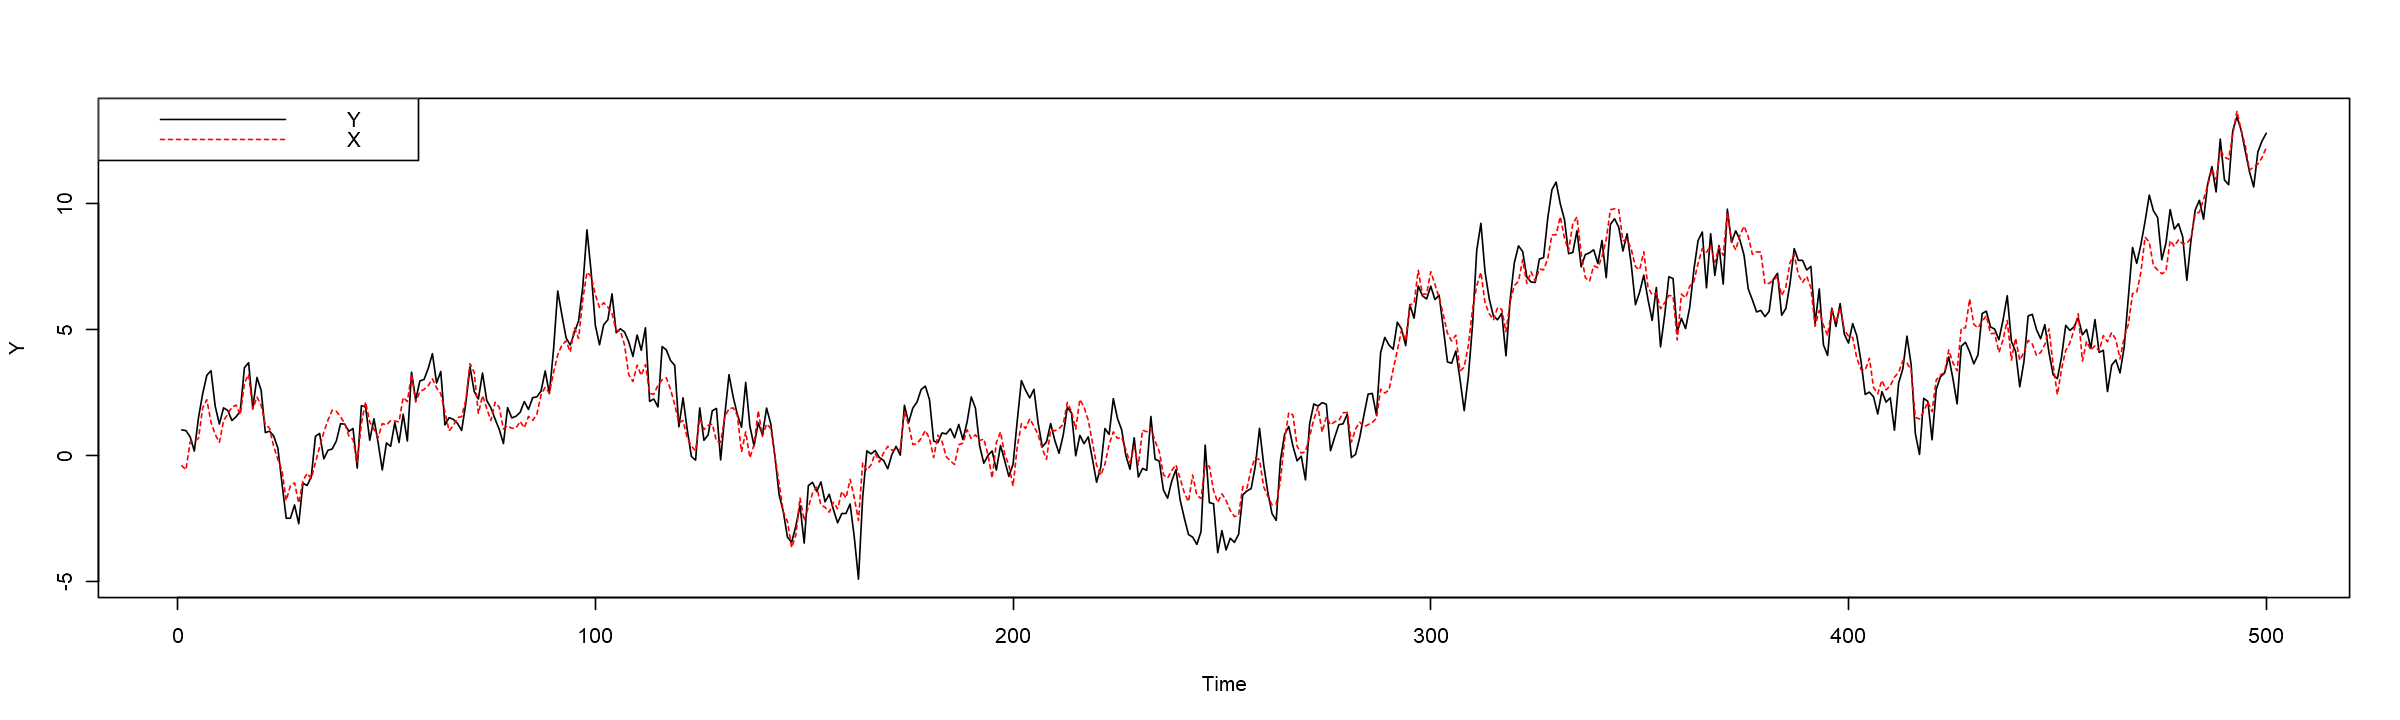

In [4]:
plot.ts(Y)
lines(ts(X), lty = 2, col = "red")
legend("topleft", legend = c("Y", "X"), lty = 1:2, col = c("black", "red"))

We can examine their ACF and CCF plots:

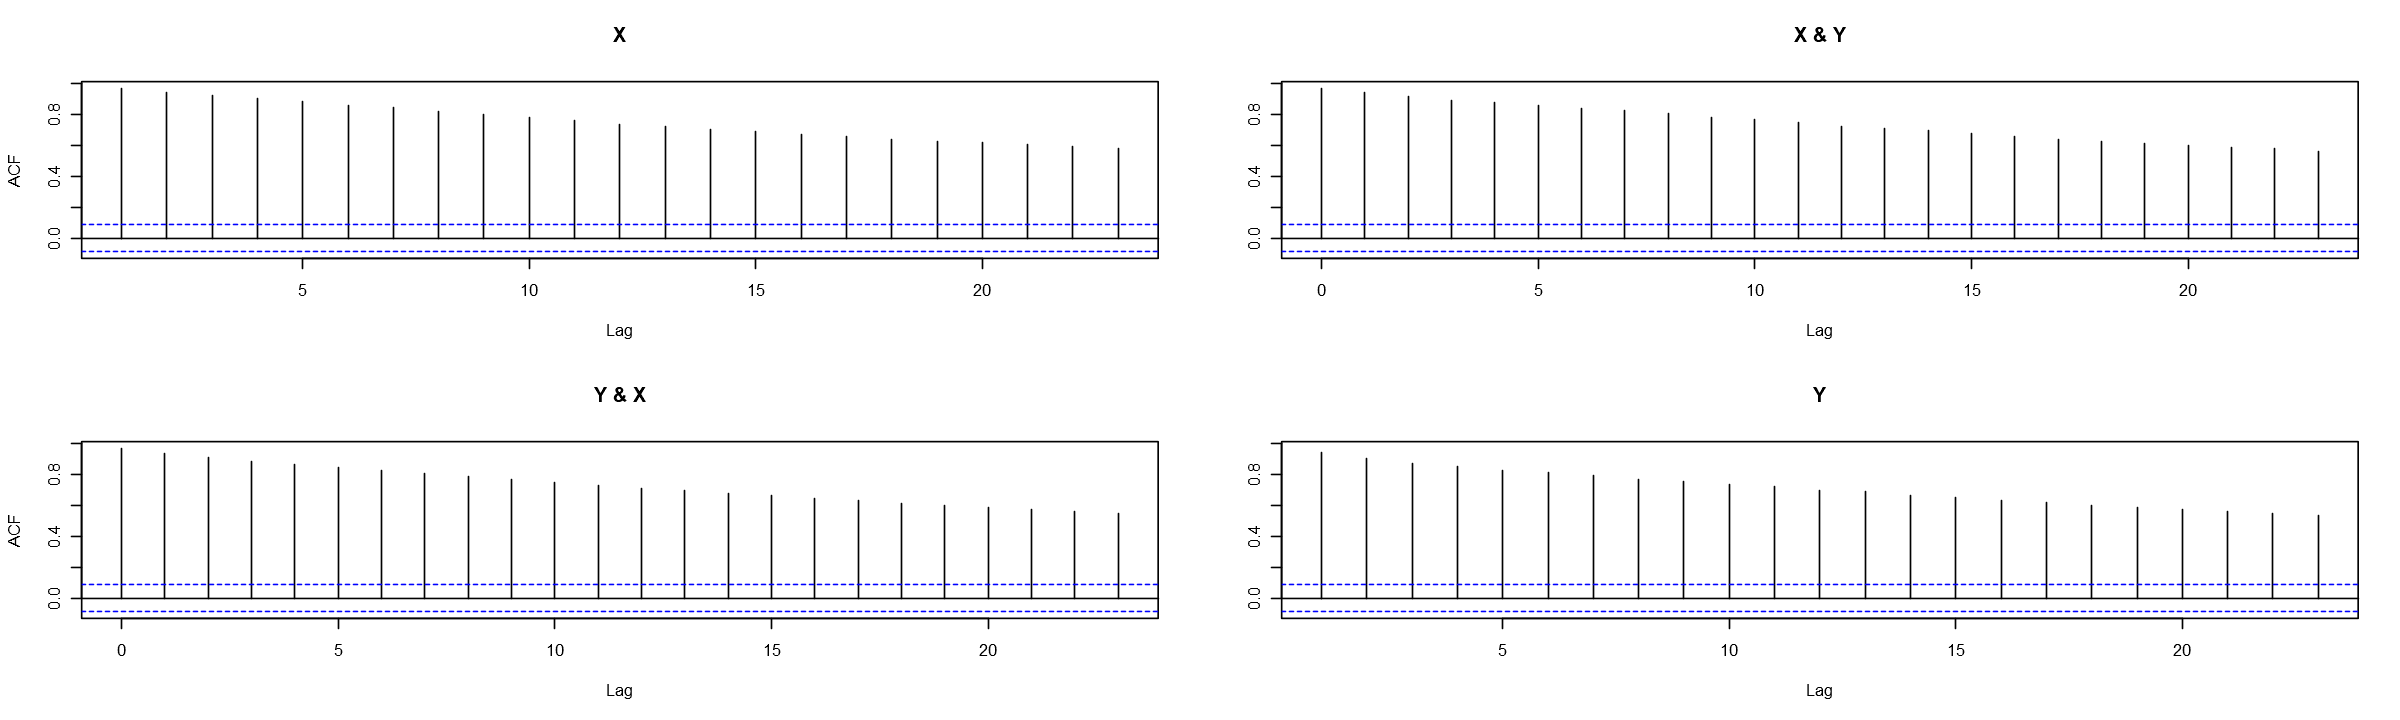

In [5]:
forecast::Acf(cbind(X, Y))

We see that the series exhibit a slowly decaying ACF and a slowly decaying CCF.

- We can test the series for the precense of a unit root:

In [6]:
tseries::adf.test(Y, alternative = "stationary")


	Augmented Dickey-Fuller Test

data:  Y
Dickey-Fuller = -2.2548, Lag order = 7, p-value = 0.4705
alternative hypothesis: stationary


In [7]:
tseries::adf.test(X, alternative = "stationary")


	Augmented Dickey-Fuller Test

data:  X
Dickey-Fuller = -1.9203, Lag order = 7, p-value = 0.612
alternative hypothesis: stationary


In both cases, we do not reject the null hypothesis of a unit root.

- We next examine the series for coitegration:

In [8]:
coint_reg <- lm(Y ~ X)

In [9]:
coef(summary(coint_reg))

Estimate    Std. Error t value    Pr(>|t|)     
(Intercept) -0.01864348 0.05471023 -0.3407676  7.334222e-01
X            1.00804449 0.01157911 87.0571908 1.872038e-303

In [10]:
coint_res <- ts(coint_reg$res)

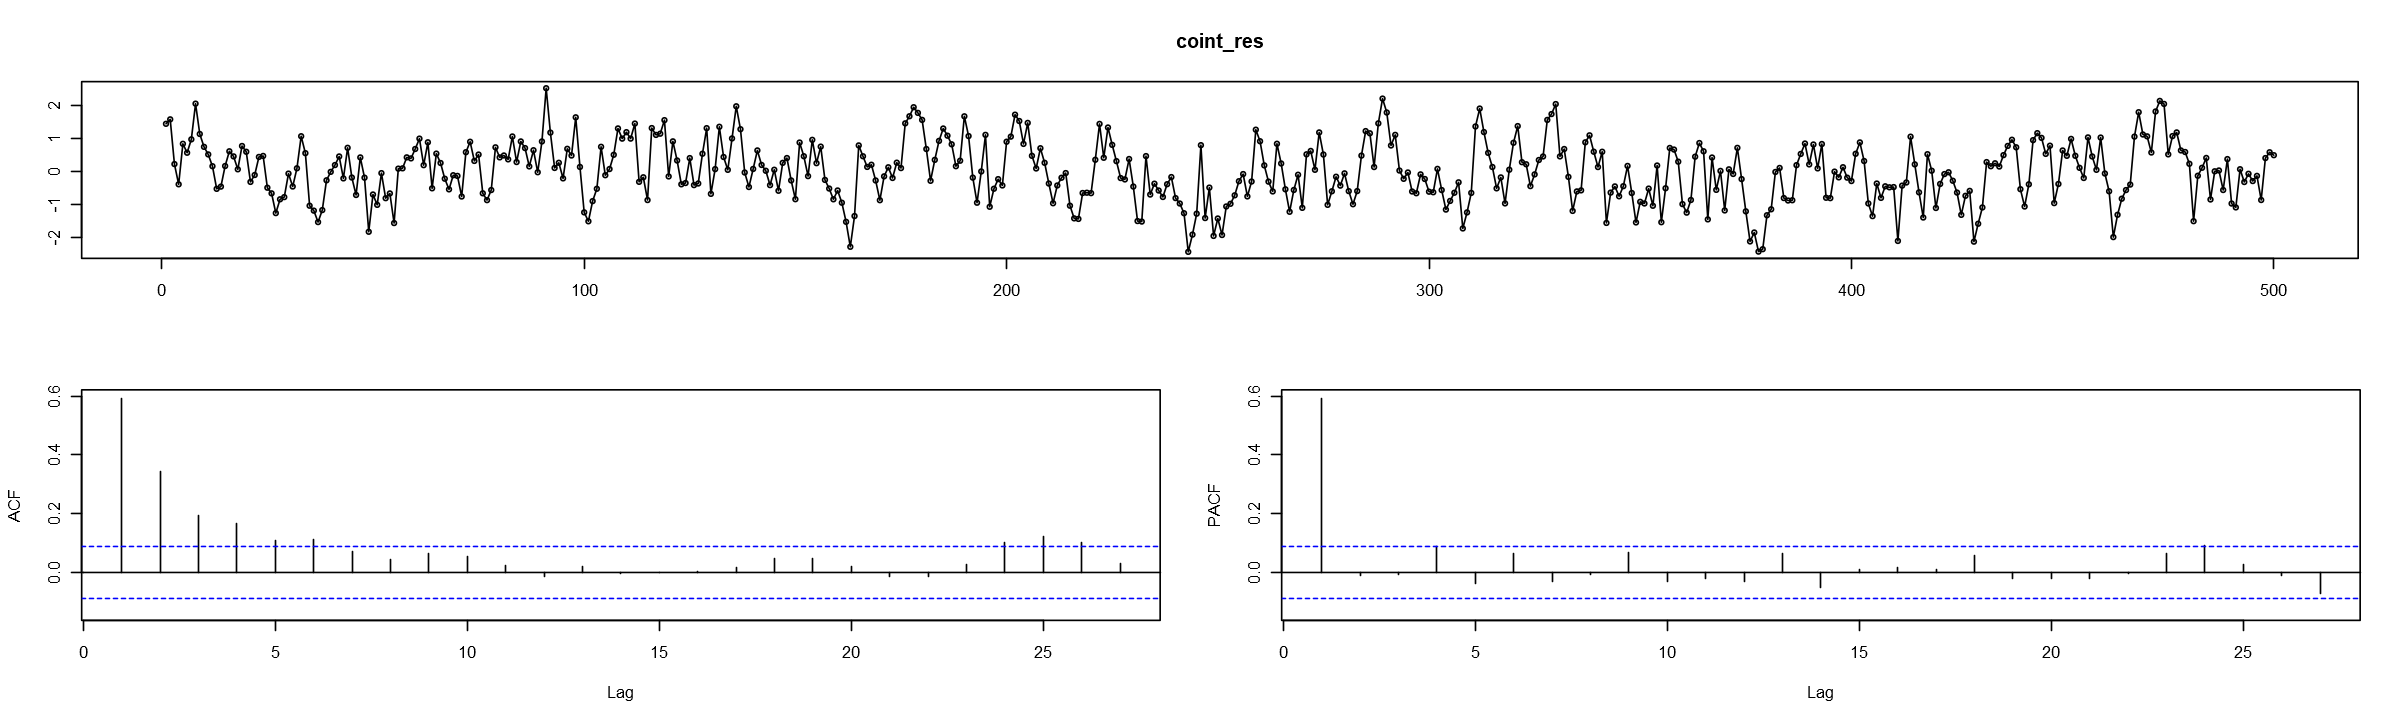

In [11]:
forecast::tsdisplay(coint_res)

In [18]:
library(dynlm)

A nive feature of using `R` (or `Python`, or any other econometric software, which allows some form of coding) is that you can automate some of the boring procedures (**only if you know that you can trust the automation process**).

In this case - we want to select the maximum lag for our residual unit root testing and reduce the maximum lag if it is insignificant - so, as this is a relatively trivial procedure, we can automate it:

In [13]:
for(max_lag in 10:0){
    print(paste0("Selecting max residual lag: ", max_lag))
    if(max_lag > 0){
        m_lag <- paste0("+ L(d(coint_res), 1:", max_lag, ")")
    }else{
        m_lag <- ""
    }
    my_formula <- paste0("d(coint_res) ~ -1 + L(coint_res)", m_lag)
    my_formula <- as.formula(my_formula)
    resid_mdl  <- dynlm(my_formula)
    if(tail(coef(summary(resid_mdl))[, 4], 1) < 0.05) break
}

[1] "Selecting max residual lag: 10"
[1] "Selecting max residual lag: 9"
[1] "Selecting max residual lag: 8"
[1] "Selecting max residual lag: 7"
[1] "Selecting max residual lag: 6"
[1] "Selecting max residual lag: 5"
[1] "Selecting max residual lag: 4"
[1] "Selecting max residual lag: 3"
[1] "Selecting max residual lag: 2"
[1] "Selecting max residual lag: 1"
[1] "Selecting max residual lag: 0"


In [14]:
round(coef(summary(resid_mdl)), 5)

Estimate Std. Error t value   Pr(>|t|)
L(coint_res) -0.40715 0.03596    -11.32324 0

The estimated residual model is:

$
\Delta e_t = \rho e_{t-1} + w_t
$

Since our long-run equilibrium equation has one xogeneous variable, $X$, and no trend, the critical value is `-3.37`. The t-statistic of `L(coint_res)` is `-11.32324`.

Since `-11.32324 < -3.37`, we reject the null hypothesis $H_0: \rho = 0$ and conclude that **the residuals do not have a unit root** (this is to be expected, since we simulate $u_t$ as  stationary $\rm AR(1)$ process. This also explains why the lagged values, `L(d(coint_res))`, we insignificant).

This means that we reject the null hypothesis of no cointegration and conclude that $Y$ and $X$ **are cointegrated**.

- We have found that $X_t, Y_t \sim I(1)$ and $X_t$ and $Y_t$ are cointegrated - we now specify the $\rm ECM$:

In [15]:
mdl_1 <- dynlm(d(Y) ~ 1 + L(coint_res) + L(d(Y), 1:3) + L(d(X), 0:3))
summary(mdl_1)


Time series regression with "ts" data:
Start = 5, End = 500

Call:
dynlm(formula = d(Y) ~ 1 + L(coint_res) + L(d(Y), 1:3) + L(d(X), 
    0:3))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.03013 -0.46723  0.00755  0.47333  1.94879 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -0.005645   0.032234  -0.175   0.8611    
L(coint_res)  -0.384014   0.048456  -7.925 1.57e-14 ***
L(d(Y), 1:3)1 -0.024785   0.051707  -0.479   0.6319    
L(d(Y), 1:3)2 -0.024013   0.048265  -0.498   0.6190    
L(d(Y), 1:3)3 -0.083953   0.044979  -1.866   0.0626 .  
L(d(X), 0:3)0  1.060436   0.046979  22.573  < 2e-16 ***
L(d(X), 0:3)1  0.074160   0.070645   1.050   0.2943    
L(d(X), 0:3)2  0.080390   0.067945   1.183   0.2373    
L(d(X), 0:3)3  0.100581   0.065631   1.533   0.1260    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7158 on 487 degrees of freedom
Multiple R-squared:  0.568,	Adjusted R-squared:  0.

Again, we see insignificant variables. No that this can also be automated and you should try to do this following the previous example.

We instead move to the finalized model:

In [16]:
mdl_1 <- dynlm(d(Y) ~ 1 + L(coint_res, 1) + L(d(X), 0))
summary(mdl_1)


Time series regression with "ts" data:
Start = 2, End = 500

Call:
dynlm(formula = d(Y) ~ 1 + L(coint_res, 1) + L(d(X), 0))

Residuals:
     Min       1Q   Median       3Q      Max 
-1.94632 -0.45223 -0.01014  0.47760  1.95487 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -0.003525   0.032058   -0.11    0.912    
L(coint_res, 1) -0.407843   0.035997  -11.33   <2e-16 ***
L(d(X), 0)       1.056106   0.046600   22.66   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7156 on 496 degrees of freedom
Multiple R-squared:  0.5606,	Adjusted R-squared:  0.5588 
F-statistic: 316.3 on 2 and 496 DF,  p-value: < 2.2e-16


Note that `L(d(X), 0)` is equivalent to `d(X)`.

The estimated model is: $\Delta Y_t = -0.003525 - 0.407843 \widehat{e}_{t-1} + 1.056106 \Delta X_t + \epsilon_t$.

where:

- The short-run multiplier of $X$ is `1.056106`;
- The long-run multiplier of $X$ is `1.00804449`, which we get from the cointegration regression:

In [17]:
coef(summary(coint_reg))

Estimate    Std. Error t value    Pr(>|t|)     
(Intercept) -0.01864348 0.05471023 -0.3407676  7.334222e-01
X            1.00804449 0.01157911 87.0571908 1.872038e-303

## **How does the ECM relate to our true model?**

Remember that we have simulated the following model:

$
\begin{cases}
Y_t &= \beta_2 X_t + u_t,\\
u_t &= \widetilde{\phi} u_{t-1} + \epsilon_t, \epsilon_t \sim I(0)\\
X_t &= X_{t-1} + v_t,\ v_t \sim I(0)
\end{cases}
$

As we have done before, we can express $u_t = Y_t - \beta_2 X_t$ to get $Y_t - \beta_2 X_t = \widetilde{\phi} Y_{t-1} - \widetilde{\phi} \beta_2 X_{t-1} + \epsilon_t$. Finally, our re-written model is:

$
Y_t = \widetilde{\phi} Y_{t-1} + \beta_2 X_t - \widetilde{\phi} \beta_2 X_{t-1} + \epsilon_t
$

Looking at the lecture slides, we see that we can re-write the model as the ECM:

$
\Delta Y_t = \beta_0 \Delta X_t - (1 - \widetilde{\phi}) \left[ Y_{t-1} - \widetilde{\beta} X_{t-1} \right] + \epsilon_t
$

where:

- $\beta_0 = \beta_2 = 1$;
- $- (1 - \widetilde{\phi}) = -0.4$;
- $\widetilde{\beta} = \beta_2 = 1$;

If we compare the true values with the estimated ones from the model output - we see that they are the same (our model also includes the intercept component, however, it is insignificant).

## **Relationship between $X_t$, $Y_t$, $u_t$ and ECM**

Note that in the above expression we got that $1 - \widetilde{\phi} \neq 0$, since $\widetilde{\phi}$ is the autoregressive parameter of $u_t$ (and **NOT** for $Y_t$).

However, this does not mean that $Y_t$ is stationary. As mentioned before, **both** $X_t$ and $Y_t$ are $I(1)$. To see why, rewrite $X_t = 1/\beta_2 (Y_t - u_t)$ and insert it into the expression of $X_t$, to get $1/\beta_2 (Y_t - u_t) = 1/\beta_2 (Y_{t-1} - u_{t-1}) + v_t$, which we can write as:

$
Y_t = Y_{t-1} + \Delta u_t + \beta_2 v_t
$

**In other words, $Y_t \sim I(1)$.** 

However the above expression contains two different random components $u_t$ and $v_t$, which we cannot evaluate separately. 


Hence why the previous expression only highlights the fact that $Y_t ~ \sim I(1)$, while the ECM form and the long-run equilibrium regression allows us to estimate all the relevant parameters.